Introduction
----
-----
------

by : Deepak Choudhary
    Atharva Gangras
    Siddhant Gavand
    




In [ ]:
!pip install imutils


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=de10b21e9d8a3348d6c40872cdae7719341603db4cd94aaebd43fea49e48174c
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model


import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics

# **Step 1:** Data Preparation and storage

Includes segmentation and creation of training and testing datasets and finally storing them in temporary folders

1-1: Create temporary folders

In [ ]:


# Define the directories to be created
directories = [
    '/content/drive/MyDrive/lukemia project/temp/prepared_data/benign',
    '/content/drive/MyDrive/lukemia project/temp/prepared_data/PreB',
    '/content/drive/MyDrive/lukemia project/temp/prepared_data/ProB',
    '/content/drive/MyDrive/lukemia project/temp/prepared_data/EarlyPreB',
    '/content/drive/MyDrive/lukemia project/temp/prepared_test/benign',
    '/content/drive/MyDrive/lukemia project/temp/prepared_test/PreB',
    '/content/drive/MyDrive/lukemia project/temp/prepared_test/ProB',
    '/content/drive/MyDrive/lukemia project/temp/prepared_test/EarlyPreB'
]

# Create the directories
for directory in directories:
    os.makedirs(directory, exist_ok=True)


1-2: Splitting data into testing data and training data (10/90)

In [ ]:
data_dir  = '/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]'
data_list = sorted(list(paths.list_images(data_dir)))



random.seed(88)
random.shuffle(data_list)

train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

print('number of testing list -:',len(test_list))
print('number of training list-:',len(train_list))

number of testing list -: 325
number of training list-: 2917


In [ ]:
print('Number of samples in dataset:',len(list(paths.list_images("/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]"))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("/content/drive/MyDrive/presentation/Blood cell Cancer [ALL]/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


1-3: Preparation and storage of test data

In [ ]:
p=0
# print(test_list)

for img in test_list[:]:
    img = os.path.normpath(img)

    i= cv2.imread(img)
    i= cv2.resize(i,(224,224))
    # print(os.path.sep)
    lable= img.split(os.path.sep)[6]
    # print(lable)
    if (lable=="Benign"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_test/benign/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_test/PreB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pro-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_test/ProB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] early Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_test/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)

In [ ]:
p=0
tic = time.perf_counter()

for img in train_list[:]:
    img = os.path.normpath(img)

    i= cv2.imread(img)
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[6]

    if (lable=="Benign"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/benign/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/PreB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pro-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/ProB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] early Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)

    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km = KMeans(n_clusters=7, random_state=0, n_init=10).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)
    out = cv2.bitwise_and(i, i, mask=m2)

    if (lable=="Benign"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/benign/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/PreB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] Pro-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/ProB/'+lable+str(p)+'.png')
    if (lable=="[Malignant] early Pre-B"):
        b= ('/content/drive/MyDrive/lukemia project/temp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)

toc2 = time.perf_counter()
print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

2917 samples processed in 38.06142614825 minutes


1-4: Preparation and storage of training data

- Description:  each original sample of the training data is segmented and then stored with the original sample as two separate samples.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


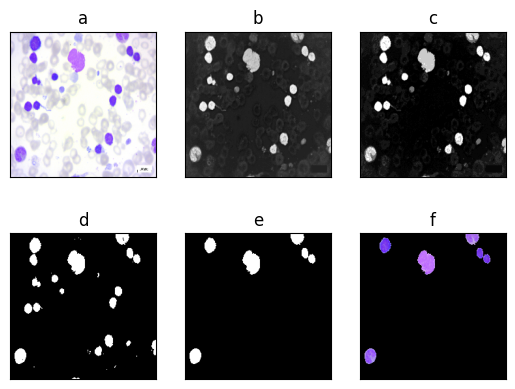

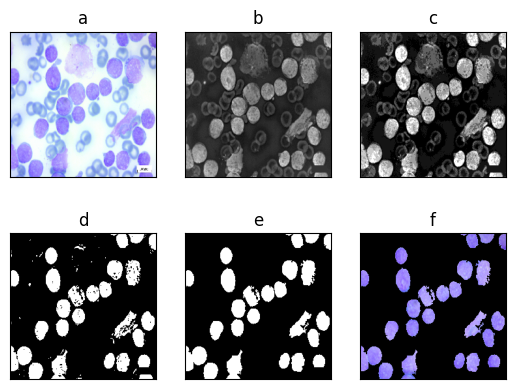

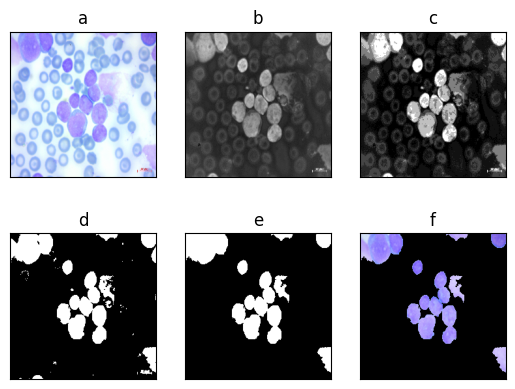

In [ ]:
#----- print some samples of training dataset -------

n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)
    fh = ndi.binary_fill_holes(t)
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)

for j in range(n):
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()

In [ ]:
#a= sorted(list(paths.list_images('/tmp/prepared_data')))
#b = cv2.imread(a[1])
#plt.imshow(b)


# **Step 2:** Prepare data for training

2-1: Create dataframe from prepared data

In [ ]:
#------- test Dataframe ---------

import os
import random
from imutils import paths  # Make sure paths is imported from imutils
import pandas as pd

prepared_data_path = '/content/drive/MyDrive/lukemia project/temp/prepared_test/'

# Get the list of all image paths and shuffle them
prepared_data_list_filenames = sorted(list(paths.list_images(prepared_data_path)))
random.shuffle(prepared_data_list_filenames)

# Extract labels from the folder names in the file paths
prepared_data_list_labels = []
for line in prepared_data_list_filenames:
    line = os.path.normpath(line)  # Normalize path separators

    # Extract the label (assuming it's the second-last folder in the path)
    prepared_data_list_labels.append(line.split(os.path.sep)[-2])

# Create a dataframe from the filenames and labels
I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat([I_series, L_series], axis=1)

# Print the test dataframe
print('-- test Dataframe --')
print(test_df.head())

# Print the number of images per class (label)
a = test_df['labels'].value_counts()
print(a)


-- test Dataframe --
                                           filenames     labels
0  /content/drive/MyDrive/lukemia project/temp/pr...       ProB
1  /content/drive/MyDrive/lukemia project/temp/pr...       PreB
2  /content/drive/MyDrive/lukemia project/temp/pr...  EarlyPreB
3  /content/drive/MyDrive/lukemia project/temp/pr...       PreB
4  /content/drive/MyDrive/lukemia project/temp/pr...       PreB
labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64


In [ ]:
# #------- train/valid Datafarame -------

# prepared_data_path = '/content/drive/MyDrive/lukemia project/temp/prepared_data/'
# # print(prepared_data_path)
# prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
# random.shuffle(prepared_data_list_filenames)
# prepared_data_list_labels = []
# # print(prepared_data_list_filenames)
# for line in prepared_data_list_filenames:
#     line = os.path.normpath(line)  # Normalize path separator

#     prepared_data_list_labels.append(line.split(os.path.sep)[3])
#     # print(line.split(os.path.sep)[3])

# I_series = pd.Series(prepared_data_list_filenames, name='filenames')
# L_series = pd.Series(prepared_data_list_labels, name='labels')
# df = pd.concat( [I_series, L_series], axis=1)

# print('-- train/valid Datafarame --')

# print(df.head())
# #print number of each class:
# a=df['labels'].value_counts()
# a

-- train/valid Datafarame --
                                           filenames   labels
0  /content/drive/MyDrive/lukemia project/temp/pr...  MyDrive
1  /content/drive/MyDrive/lukemia project/temp/pr...  MyDrive
2  /content/drive/MyDrive/lukemia project/temp/pr...  MyDrive
3  /content/drive/MyDrive/lukemia project/temp/pr...  MyDrive
4  /content/drive/MyDrive/lukemia project/temp/pr...  MyDrive
labels
MyDrive    5834
Name: count, dtype: int64


In [ ]:
import os
import random
from imutils import paths  # Ensure you've imported paths from imutils
import pandas as pd

#------- train/valid Dataframe -------
prepared_data_path = '/content/drive/MyDrive/lukemia project/temp/prepared_data/'

# Get a list of all image paths and shuffle them
prepared_data_list_filenames = sorted(list(paths.list_images(prepared_data_path)))
random.shuffle(prepared_data_list_filenames)

# Extract labels from the folder names in the file paths
prepared_data_list_labels = []
for line in prepared_data_list_filenames:
    line = os.path.normpath(line)  # Normalize path separator

    # Extract the label which is expected to be the 4th element in the path
    prepared_data_list_labels.append(line.split(os.path.sep)[-2])

# Create a dataframe from the filenames and labels
I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat([I_series, L_series], axis=1)

# Print the dataframe head
print('-- train/valid Dataframe --')
print(df.head())

# Print the number of images per class (label)
a = df['labels'].value_counts()
print(a)


-- train/valid Dataframe --
                                           filenames     labels
0  /content/drive/MyDrive/lukemia project/temp/pr...       ProB
1  /content/drive/MyDrive/lukemia project/temp/pr...  EarlyPreB
2  /content/drive/MyDrive/lukemia project/temp/pr...       ProB
3  /content/drive/MyDrive/lukemia project/temp/pr...       PreB
4  /content/drive/MyDrive/lukemia project/temp/pr...       PreB
labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# print(a[0])
sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(df.index)), ['a', 'b'])
plt.show()

NameError: name 'a' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  5250
Valid samples:  584
Test samples :  325


In [ ]:
test_df['labels'].value_counts()

labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64

2-3: Augmentation, normalize and building data generators

In [ ]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

gen = ImageDataGenerator(rescale=1./255,
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 325,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 5250 validated image filenames belonging to 4 classes.
Found 584 validated image filenames belonging to 4 classes.
Found 325 validated image filenames belonging to 4 classes.
164


In [ ]:
#images, labels = next(train_gen)
#plt.imshow(images[4])

#prepared_data_path = '/tmp/prepared_data/'
#a = (sorted(list(paths.list_images(prepared_data_path))))
#b=cv2.imread(a[6])
#plt.imshow(b)
#train_gen.labels

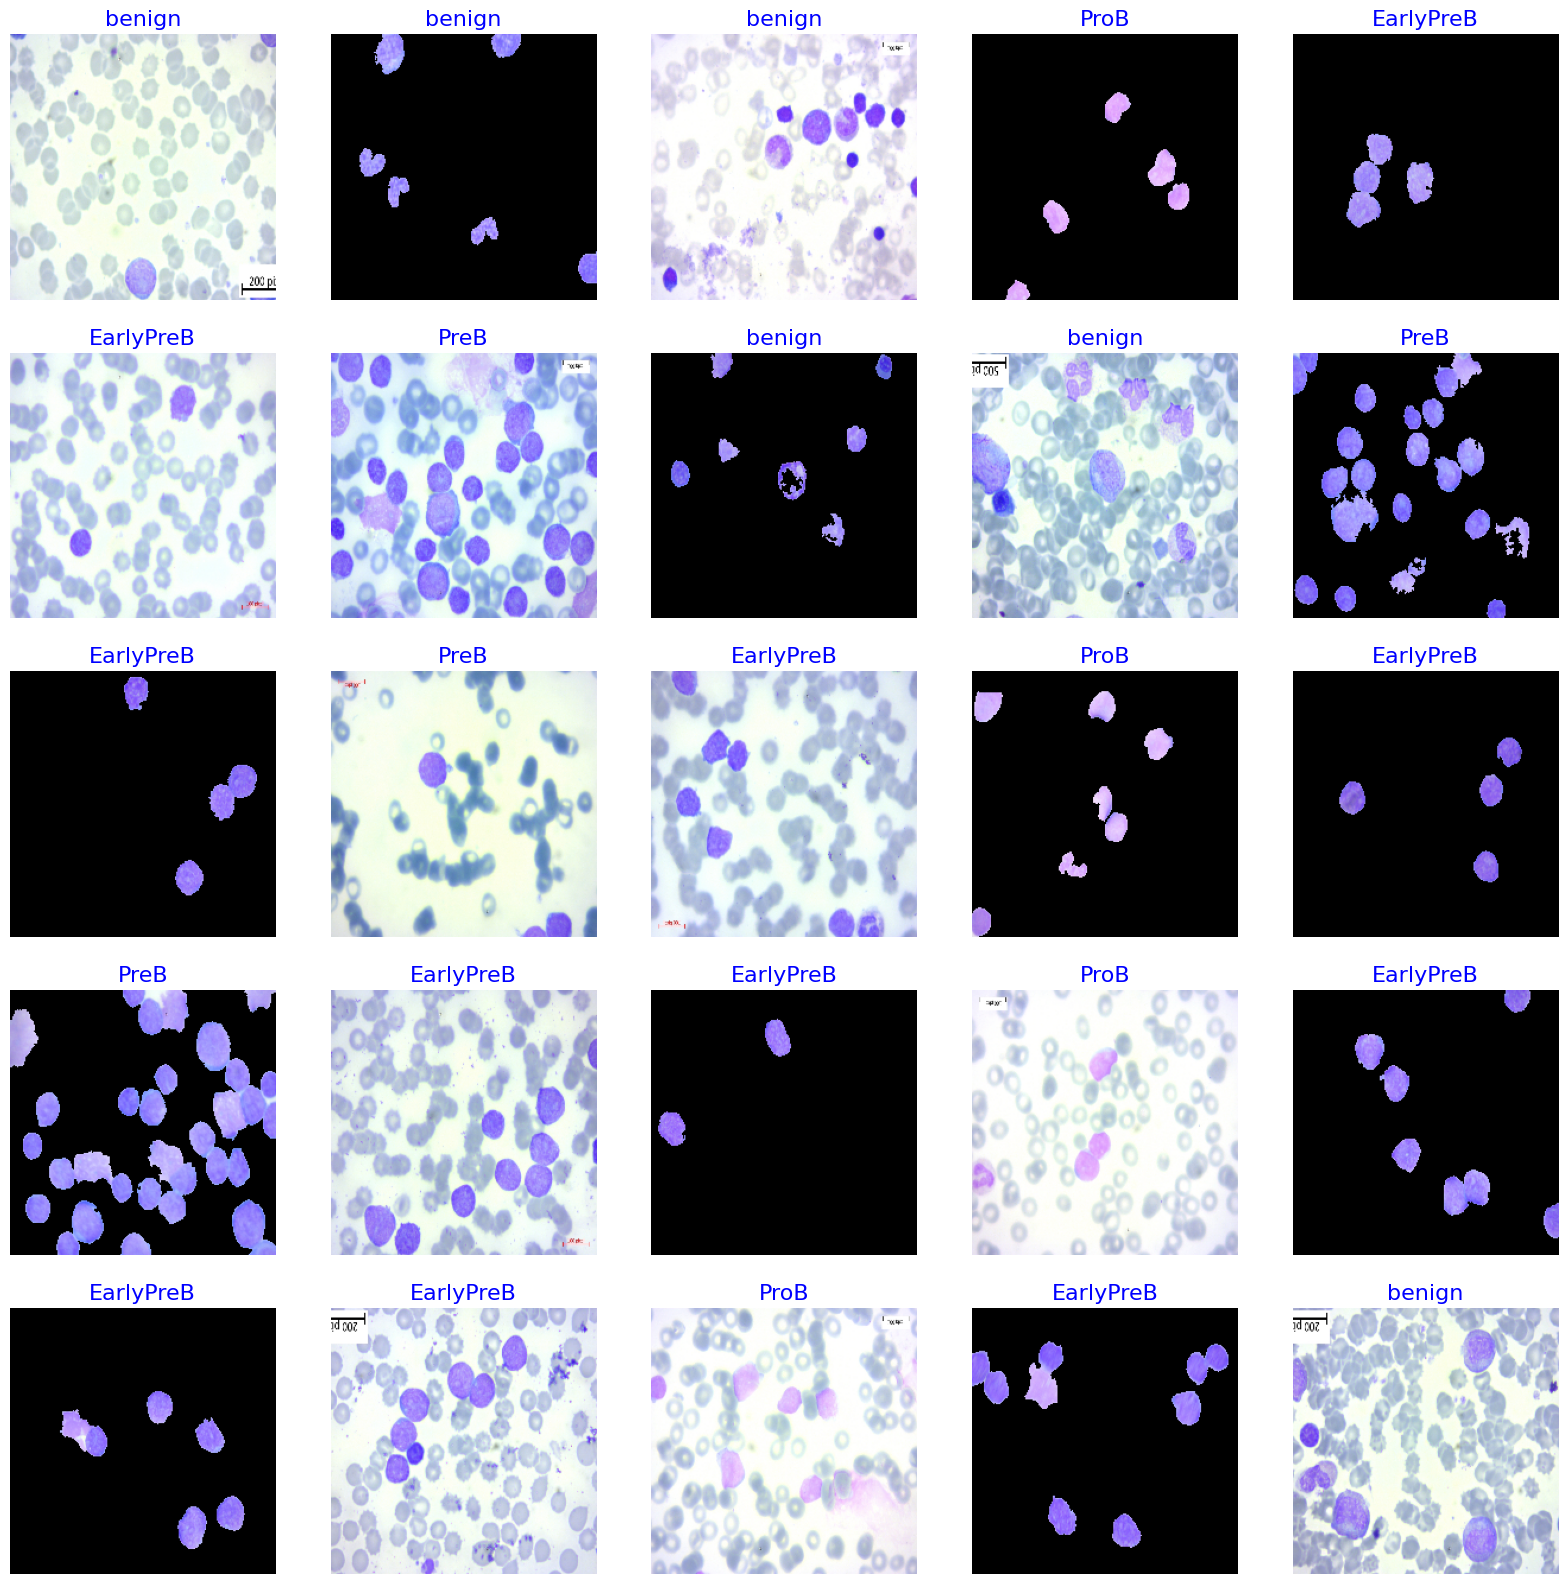

In [ ]:
#---- print 25 samples of trainig dataset -----

genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

# **Step 3:** Model creation and model training

3-1: Create the base model

In [ ]:
#base_model = InceptionV3(include_top= False, weights="imagenet", input_shape=(224,224,3))
#base_model= tf.keras.applications.efficientnet.EfficientNetB0(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.nasnet.NASNetLarge
#base_model= tf.keras.applications.nasnet.NASNetMobile(include_top=False,weights='imagenet',input_shape=(224,224,3))
base_model= tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.MobileNetV3Small

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)
predictions = Dense(4, activation= "softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
#print(base_model.input)
#model.summary()

3-2: Model parameters

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
              metrics=['accuracy'])
             # option = run_opts)

3-2: Model training

In [ ]:
history =         model.fit(x=train_gen,
                            epochs=30,
                            validation_data=valid_gen,
                            steps_per_epoch=None,
                            # workers=2
                   )

Epoch 1/30
165/165 [==============================] - 1346s 8s/step - loss: 0.2878 - accuracy: 0.8924 - val_loss: 1.5700 - val_accuracy: 0.4024
Epoch 2/30
165/165 [==============================] - 135s 816ms/step - loss: 0.1016 - accuracy: 0.9606 - val_loss: 2.4587 - val_accuracy: 0.4247
Epoch 3/30
165/165 [==============================] - 137s 827ms/step - loss: 0.0708 - accuracy: 0.9762 - val_loss: 1.9548 - val_accuracy: 0.4606
Epoch 4/30
165/165 [==============================] - 131s 796ms/step - loss: 0.0627 - accuracy: 0.9775 - val_loss: 1.4110 - val_accuracy: 0.5908
Epoch 5/30
165/165 [==============================] - 130s 789ms/step - loss: 0.0505 - accuracy: 0.9829 - val_loss: 1.3019 - val_accuracy: 0.6627
Epoch 6/30
165/165 [==============================] - 131s 795ms/step - loss: 0.0393 - accuracy: 0.9882 - val_loss: 1.0729 - val_accuracy: 0.7295
Epoch 7/30
165/165 [==============================] - 131s 794ms/step - loss: 0.0321 - accuracy: 0.9886 - val_loss: 0.9740 - v

# **Step 4:** Results

Includes accuracy and loss charts, Confusion matrix, and stuff

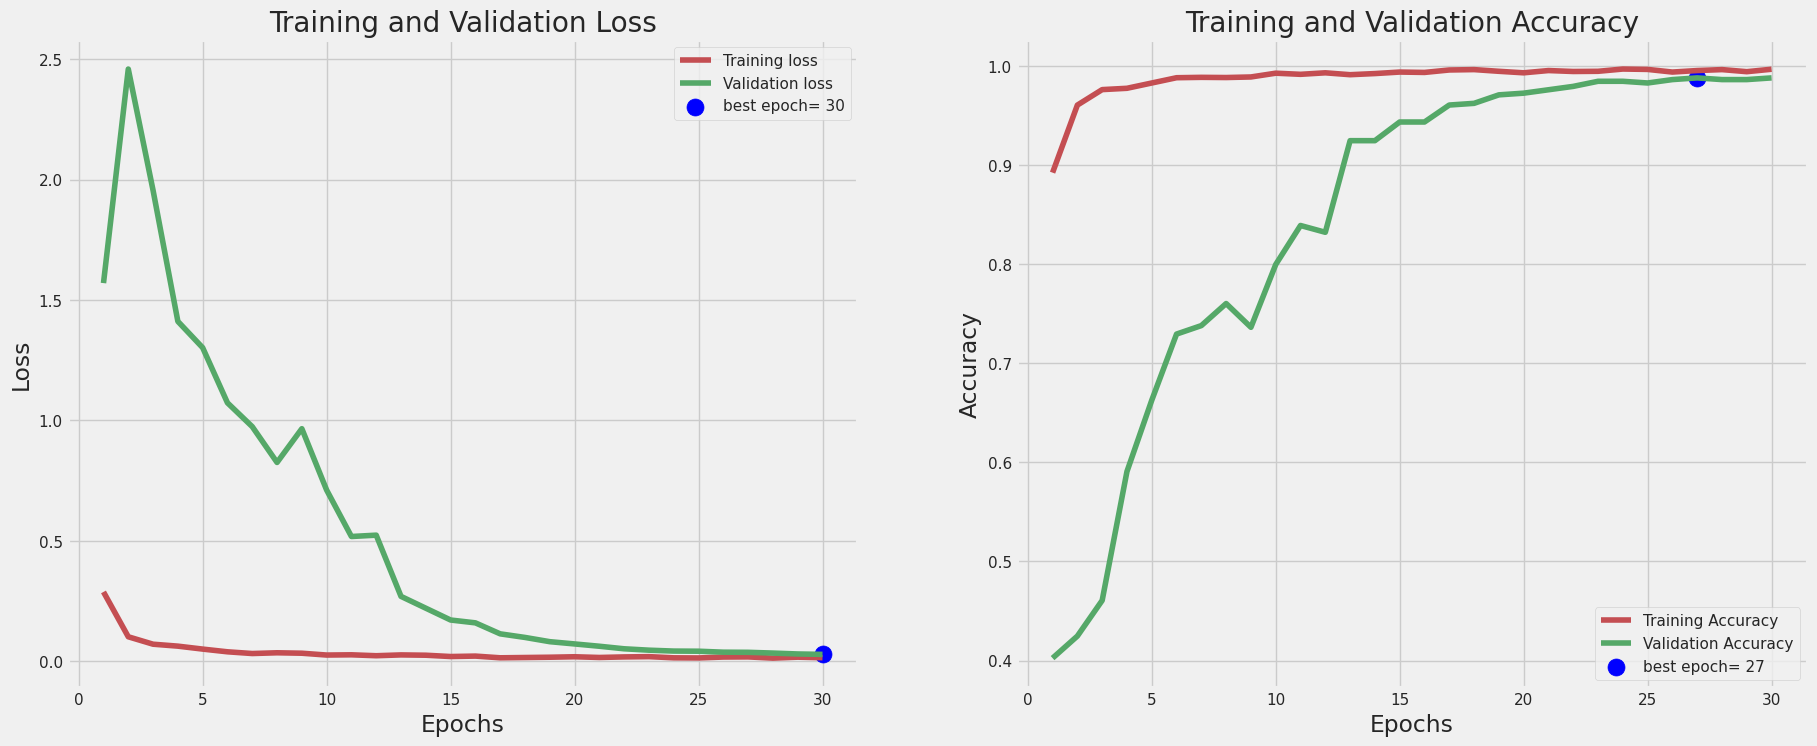

1/1 [==============================] - 4s 4s/step - loss: 0.0103 - accuracy: 0.9938
Model accuracy on test set: 99.38461780548096 (0, 255, 0) (55, 65, 80)


In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))

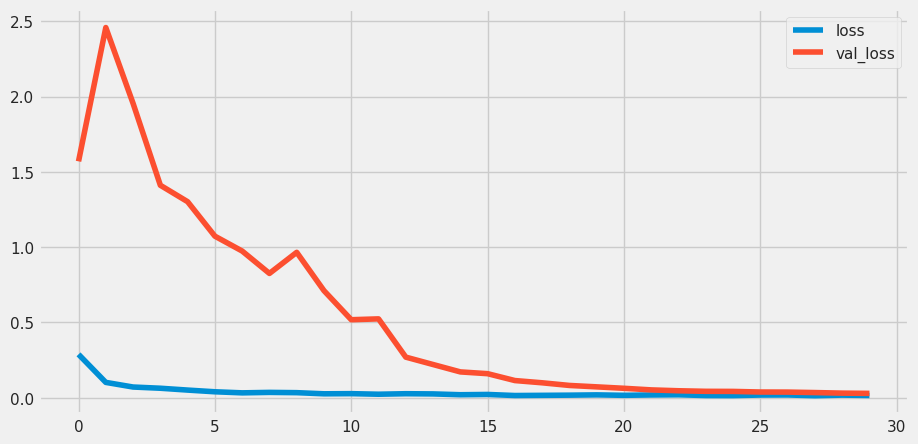

In [ ]:
# Plotting train_loss vs val_loss
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend()

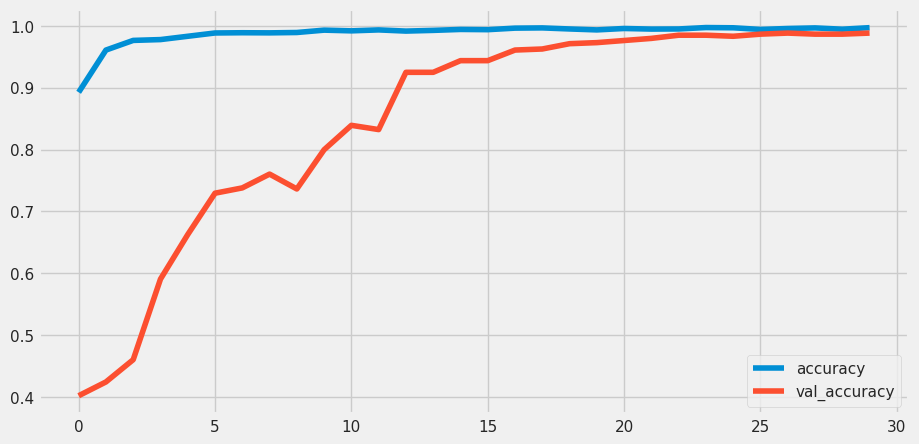

In [ ]:
# Plotting train_accuracy vs Val_accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='lower right')

In [ ]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break

print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (325, 4)
test image shape (325, 224, 224, 3)
Evaluate on test-data:
11/11 [==============================] - 2s 145ms/step
Confusion Matrix:
 [[110   0   0   1]
 [  1  92   0   0]
 [  0   0  78   0]
 [  0   0   0  43]]


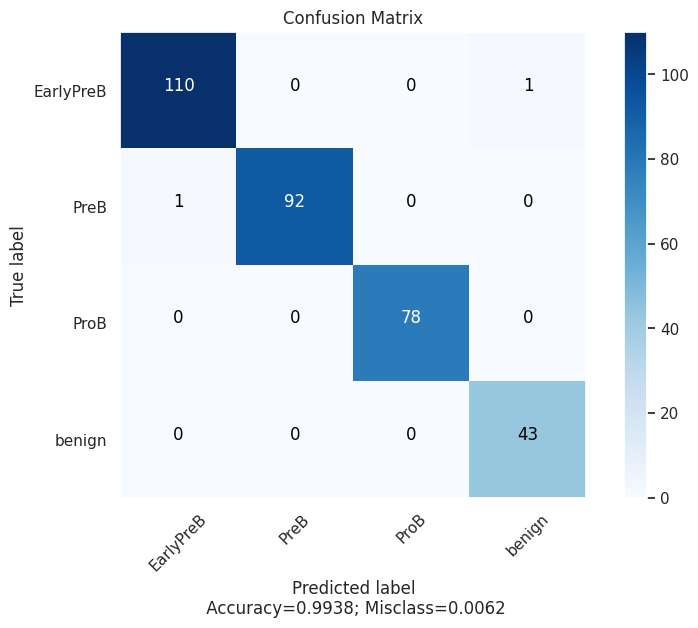

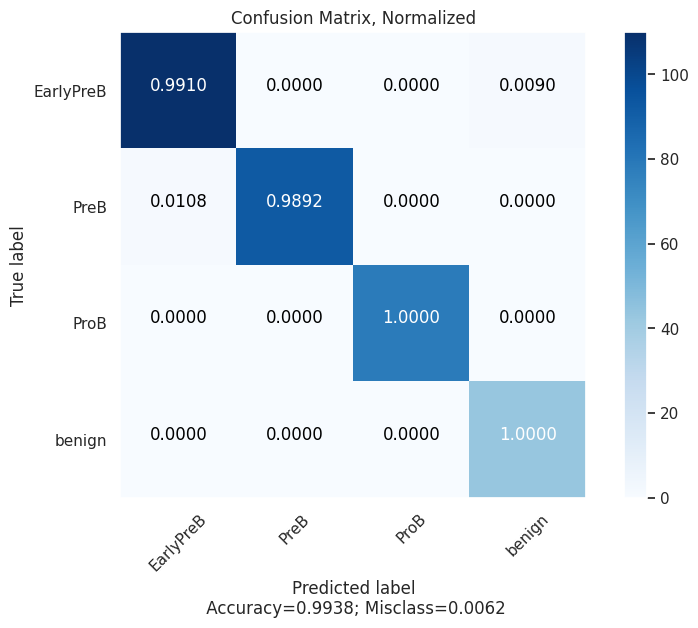

In [ ]:
import itertools

#Plot the Confusion matrix:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix),
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized")



In [ ]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       111
           1       1.00      0.99      0.99        93

   micro avg       1.00      0.99      0.99       204
   macro avg       1.00      0.99      0.99       204
weighted avg       1.00      0.99      0.99       204



In [ ]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP)
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (positive predictive value)-------------:', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate)------------------:', TNR)
print('Negative Predictive Value-------------------------:', NPV)
print('Fall out (false positive rate)--------------------:', FPR)
print('False Negative Rate-------------------------------:', FNR)
print('False discovery rate------------------------------:', FDR)

Other Metrics:
MAE ----------------------------------------------: 0.012307692307692308
Accuracy -----------------------------------------: [0.99384615 0.99692308 1.         0.99692308]
Precision (positive predictive value)-------------: [0.99099099 1.         1.         0.97727273]
Recall (Sensitivity, hit rate, true positive rate): [0.99099099 0.98924731 1.         1.        ]
Specificity (true negative rate)------------------: [0.9953271 1.        1.        0.9964539]
Negative Predictive Value-------------------------: [0.9953271  0.99570815 1.         1.        ]
Fall out (false positive rate)--------------------: [0.0046729 0.        0.        0.0035461]
False Negative Rate-------------------------------: [0.00900901 0.01075269 0.         0.        ]
False discovery rate------------------------------: [0.00900901 0.         0.         0.02272727]


11/11 [==============================] - 1s 129ms/step
Shape of preds:  (325, 4)


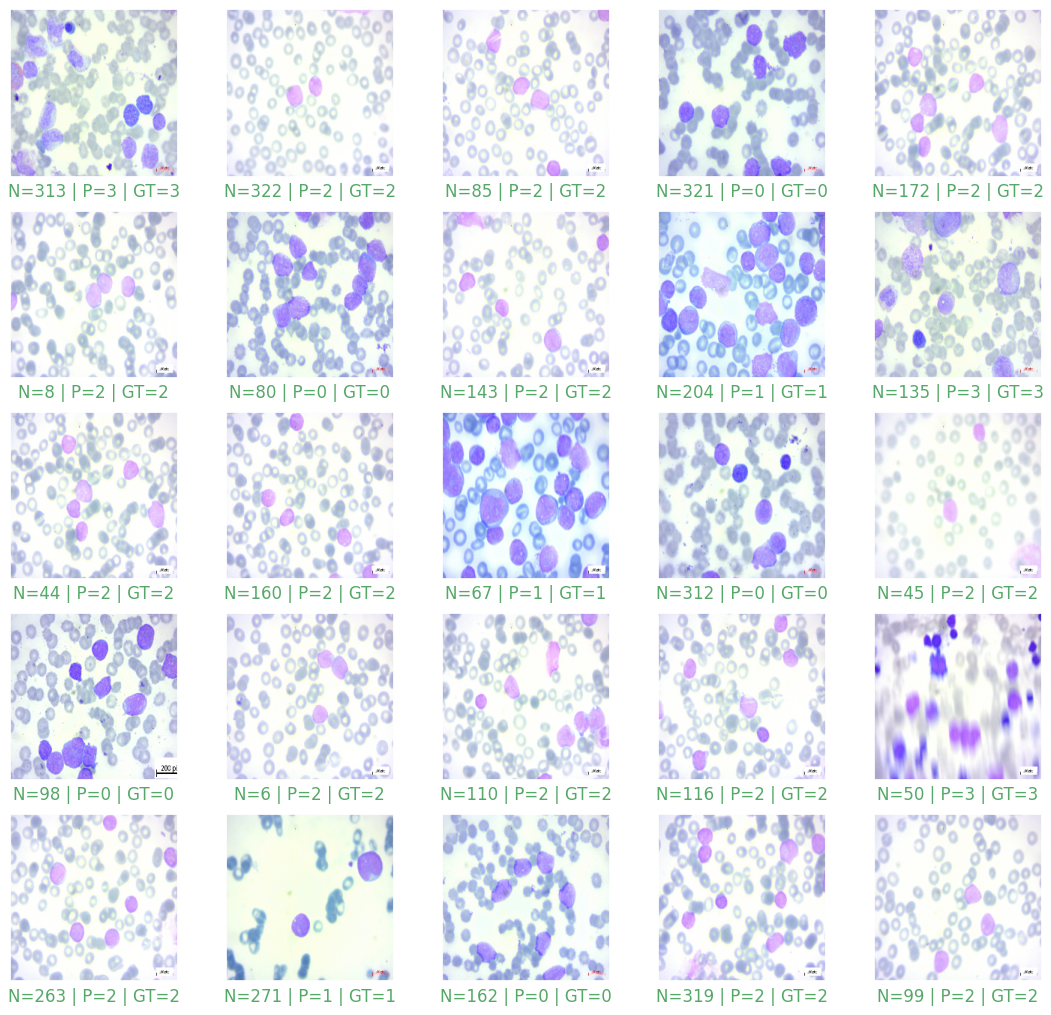

In [ ]:
preds = model.predict(X_test)
#print(preds)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

number = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    number = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[number])
    actual = (y_test[number])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
    image= X_test[number]#cv2.cvtColor(X_test[number], cv2.COLOR_BGR2RGB)
    plt.imshow(((image* 255).astype(np.uint8)), cmap='binary')
plt.show()

# **Step 5:** Save the model


In [ ]:
import tensorflow as tf

# Save the Keras model
model.save('/content/drive/MyDrive/lukemia project/MobileNetV2/mobilenetv2_model.h5')

# Convert the model to TensorFlow.js format
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras \
    /content/drive/MyDrive/lukemia project/MobileNetV2/mobilenetv2_model.h5 \
    /content/drive/MyDrive/lukemia project/MobileNetV2/web_model/

print("Model successfully converted to TensorFlow.js format and saved in 'web_model' directory.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 793.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 615.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully u

2024-09-15 10:26:49.700165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 10:26:49.719925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 10:26:49.725494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 10:26:50.901535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {keras_keras,tfjs_layers_model,tf_saved_model,tf_hub,keras,tf_frozen_model,keras_saved_model}]
                                       [--outpu

In [ ]:
# Define paths
keras_model_path = '/content/drive/MyDrive/lukemia project/MobileNetV2/mobilenetv2_model.h5'
tfjs_model_path = '/content/drive/MyDrive/lukemia project/MobileNetV2/web_model/'

# Install TensorFlow.js converter
!pip install tensorflowjs

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format keras \
    "{keras_model_path}" \
    "{tfjs_model_path}"

print(f"Model successfully converted to TensorFlow.js format and saved in '{tfjs_model_path}'")


In [ ]:
# Define paths
keras_model_path = '/content/drive/MyDrive/lukemia_project/MobileNetV2/mobilenetv2_model.h5'
tfjs_model_path = '/content/drive/MyDrive/lukemia_project/MobileNetV2/web_model'

# Install TensorFlow.js converter
# !pip install tensorflowjs

# Convert the model to TensorFlow.js format
!tensorflowjs_converter --input_format keras \
    "{keras_model_path}" \
    "{tfjs_model_path}"

print(f"Model successfully converted to TensorFlow.js format and saved in '{tfjs_model_path}'")


2024-09-15 11:03:40.519839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 11:03:40.565155: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 11:03:40.579316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 11:03:40.623171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 11:03:43.748296: W tensorflow/compiler/tf2

In [ ]:
# from tensorflow import lite


# #!ls /
# # !ls /kaggle/working
# # !mkdir /kaggle/working/model4

# converter = lite.TFLiteConverter.from_keras_model(model)
# tfmodel = converter.convert()
# open ('/content/drive/MyDrive/lukemia project/MobileNetV2/mobilenetv2_model.tflite','wb').write(tfmodel)

# #model.save("./Model1/model1")

In [ ]:
# import os
# os.chdir(r'./')
# from IPython.display import FileLink
# FileLink(r'./model4/model4.tflite')

/content/drive/MyDrive/lukemia_project/MobileNetV2/model1 (MobileNetV2) (2).tflite

In [ ]:
# # zip file
# import shutil
# shutil.make_archive('model3', 'zip', "./model3")

'/content/model3.zip'

In [ ]:
# import os
# os.chdir(r'./')
# from IPython.display import FileLink
# FileLink(r'model3.zip')